In [22]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

## Step 1. 실험환경 Set-up

In [23]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
TRAIN_PATH = './chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = './chest_xray/data/val/*/*'
TEST_PATH = './chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 25

## Step 2. 데이터 준비하기
validation 데이터의 크기가 16으로 너무 작아 train 데이터와 합쳐주어 train 데이터로 사용하겠습니다.

In [24]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [25]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [26]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [27]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

- 데이터를 텐서플로우 Dataset으로 변환하여 학습연산을 효율적으로 처리할 수 있습니다.

In [28]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


## 데이터 전처리

In [29]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [30]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [31]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test 데이터도 train 데이터와 마찬가지로 변환해줍니다.

In [32]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [33]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


>```py
    def augment(image,label):
        image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
        return image,label
    def prepare_for_training(ds, shuffle_buffer_size=1000):
        # augment 적용 부분이 배치처리 함수에 추가되었습니다.
        ds = ds.map(
                augment,       # augment 함수 적용
                num_parallel_calls=2
            )
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.repeat()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
    train_ds = prepare_for_training(train_ds)
    val_ds = prepare_for_training(val_ds)
    ```

    위의 코드를 대신 사용하여 램덤하게 좌우반전시킨 이미지도 학습할 수 있습니다.
    하지만 의료 데이터의 경우 augmentation을 적용하였을 경우 성능향상이 없을 수 있고, recall을 고려해야하기에 신중히 사용하여야합니다.

## Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다. augmentation을 해준 경우 좌우반전된 모습을 확인할 수 있습니다.

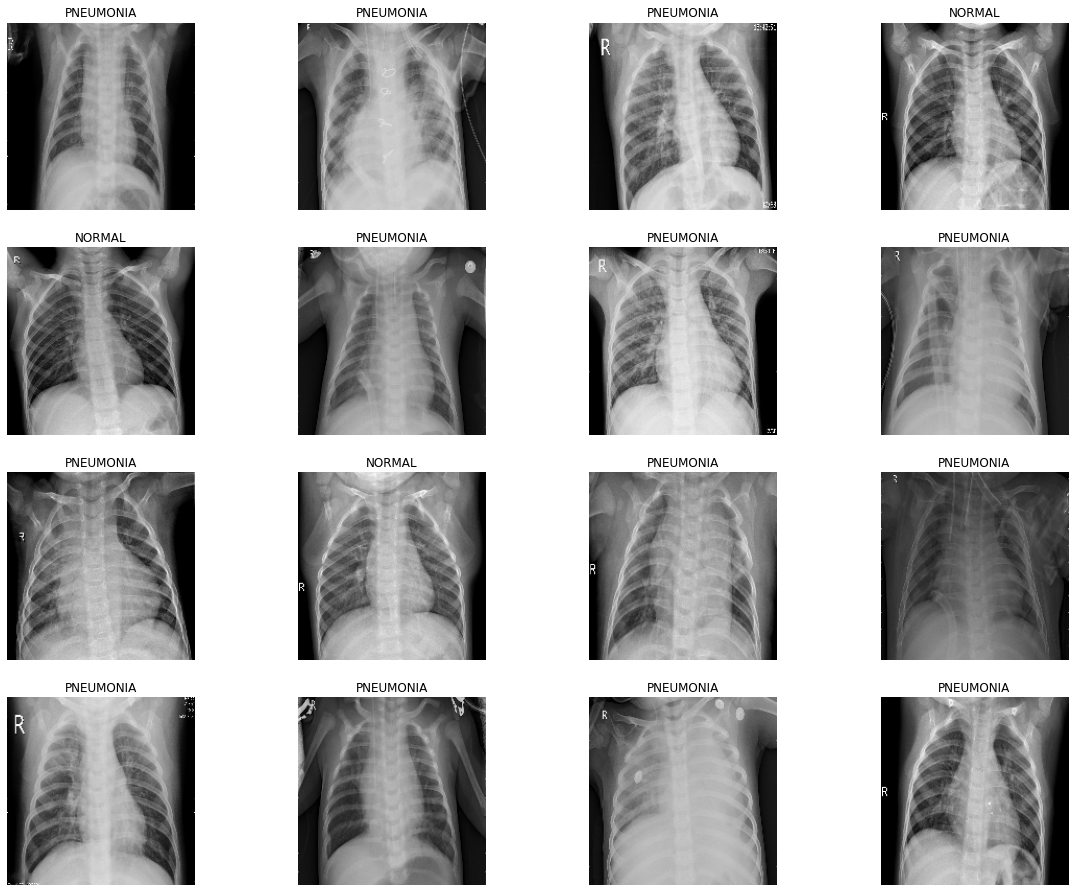

In [34]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

In [35]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [36]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [37]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),#7 5 3
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 줍니다.<br>
imbalance 처리를 생략한다면 데이터가 불균형해지므로 불균형한 데이터는 이상 데이터를 정확히 찾아내지 못할 수 있습니다.<br>

In [38]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련

In [39]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [40]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 59s 193ms/step - loss: 0.4062 - accuracy: 0.7828 - precision: 0.9475 - recall: 0.7495 - val_loss: 0.6564 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2516 - accuracy: 0.9016 - precision: 0.9687 - recall: 0.8966 - val_loss: 1.3736 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2091 - accuracy: 0.9140 - precision: 0.9758 - recall: 0.9070 - val_loss: 0.0993 - val_accuracy: 0.9644 - val_precision: 0.9667 - val_recall: 0.9856
Epoch 4/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1991 - accuracy: 0.9203 - precision: 0.9770 - recall: 0.9144 - val_loss: 0.1158 - val_accuracy: 0.9510 - val_precision: 0.9452 - val_recall: 0.9909
Epoch 5/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1747 - accura

## Step 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다.

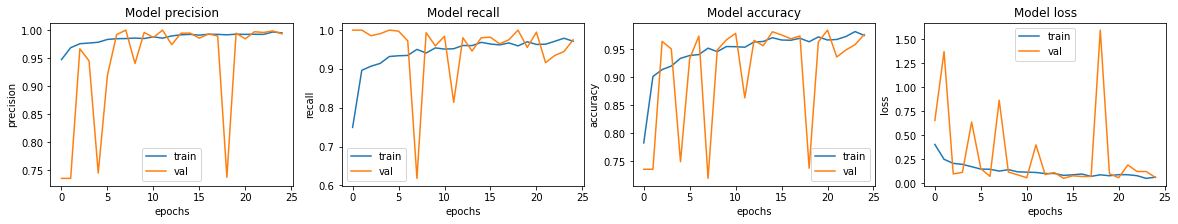

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 1.2312 - accuracy: 0.7788 - precision: 0.7405 - recall: 0.9949
Loss: 1.2312227487564087,
Accuracy: 0.7788461446762085,
Precision: 0.7404580116271973,
Recall: 0.9948717951774597


>default(BATCH_SIZE = 16, EPOCH = 25)
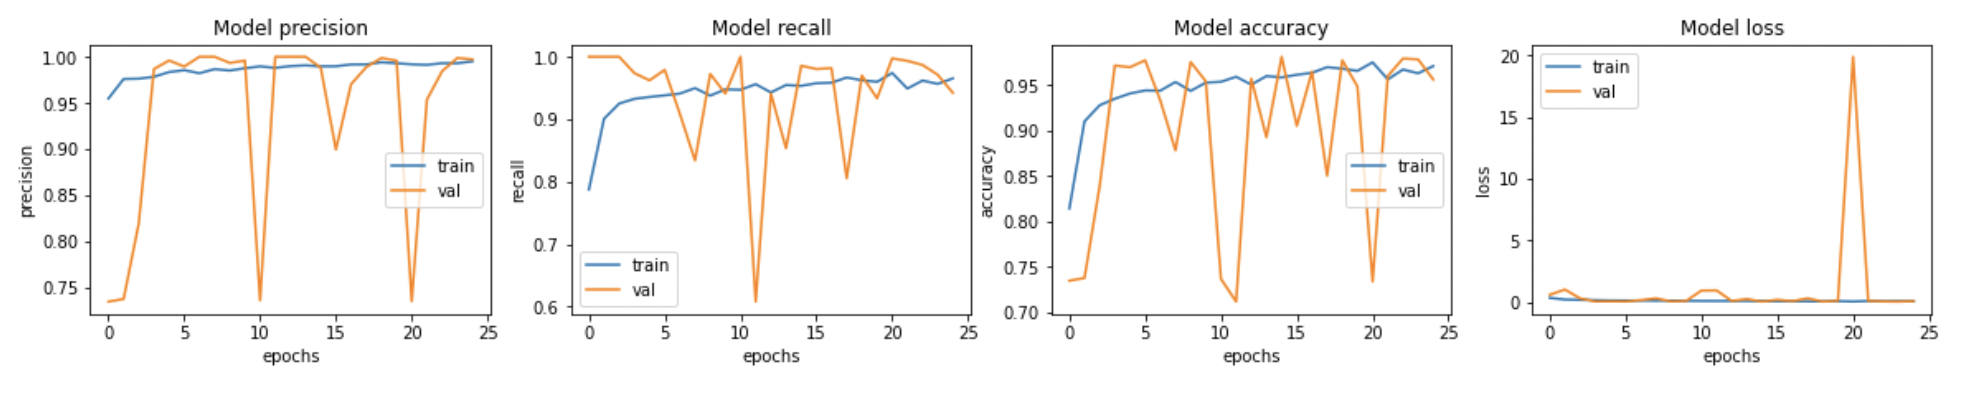
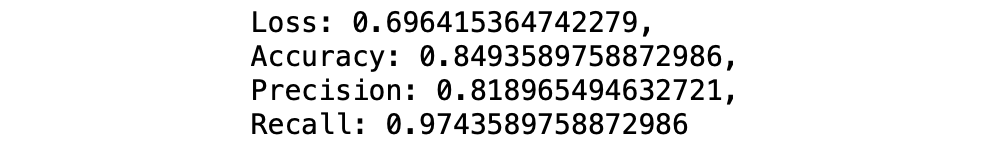

>BATCH_SIZE = 32, EPOCH = 25
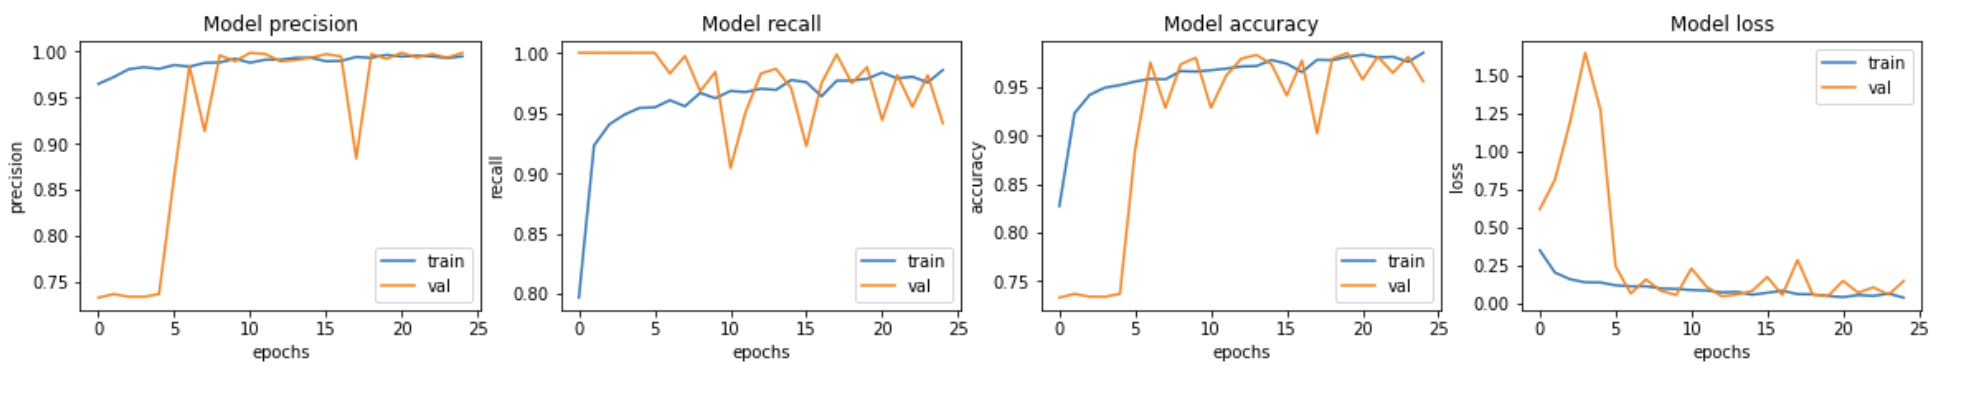
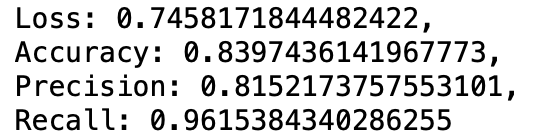


>augmentation을 적용한 경우
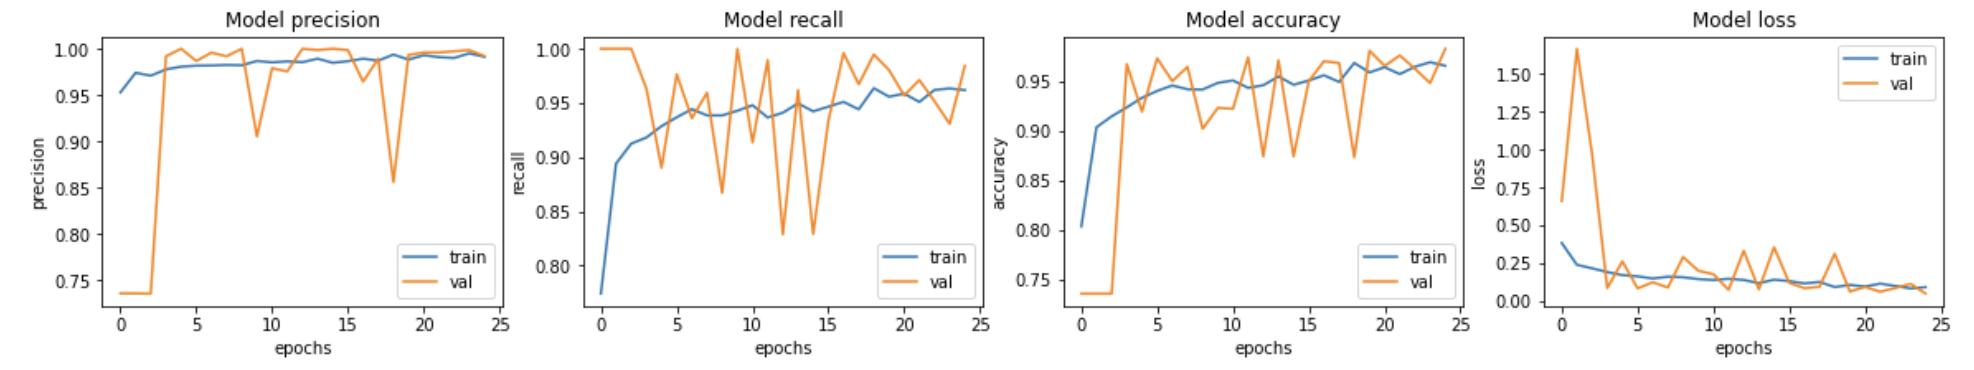
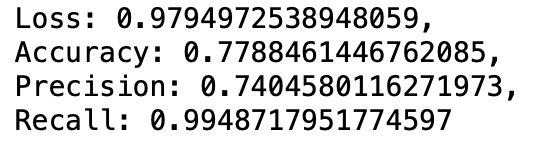

>dropout을 사용하지 않은 경우
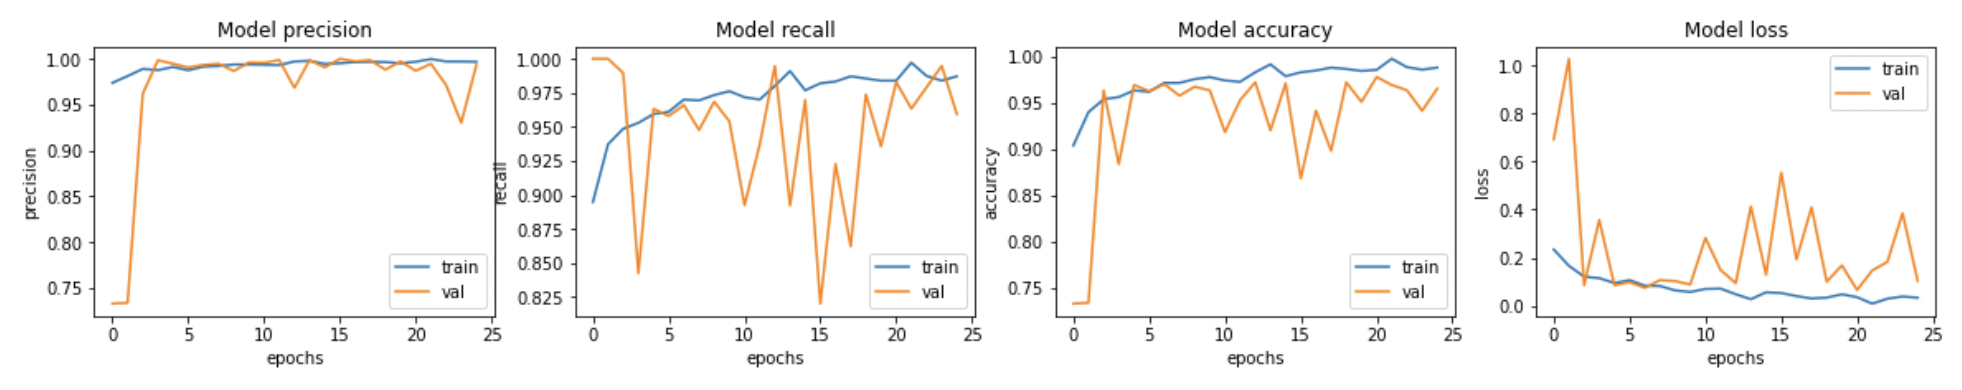
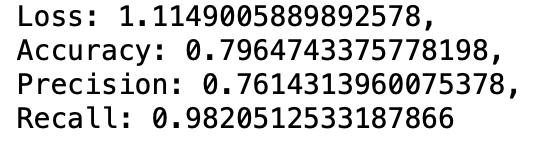

>batch normalization을 사용하지 않은 경우
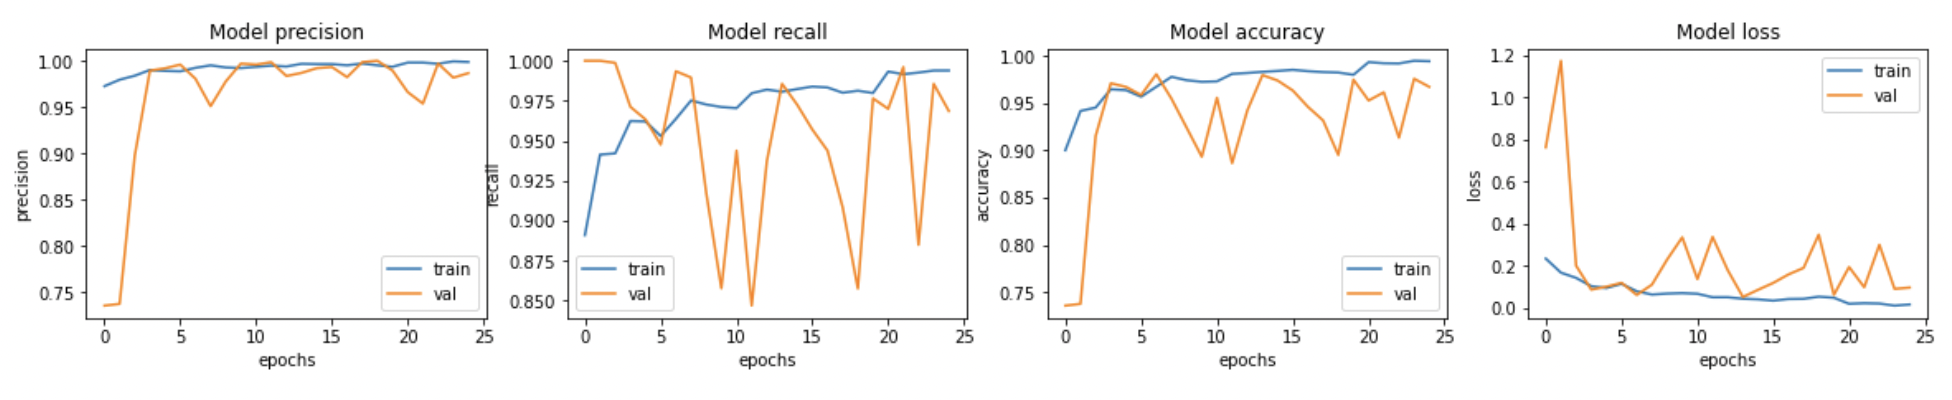
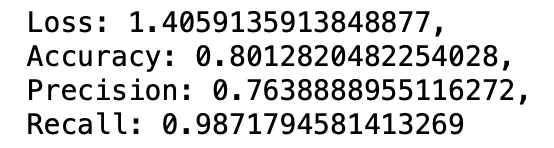


___
## 회고
augmentation을 처음에는 단어의 의미처럼 단순히 데이터의 수를 증가시키는 것인 줄 알았는데 데이터의 수를 증가시키는 것은 augmentation의 한 가지 방법 중 하나였고, augmentation은 데이터의 질을 높이는 것이라는 것을 알게 되었습니다. 하지만 augmentation을 무작정 사용한다고 성능이 개선되지는 않습니다.<br>
또한 레이어를 블록 단위로 묶어 모델을 설계하는 방법, batch normalization 및 dropout에 대해서도 좀 더 자세히 공부하였고, imbalance처리를 통해 불균형 데이터에 대한 보완방법에 대해서도 이해할 수 있었습니다.